In [1]:
import math
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def train_test_split(window_size):
    data = np.load("./dataset/pems-traffic-flow/PEMS04.npz")
    pem04 = data['data']
    scaler_data = np.zeros((pem04.shape[0], pem04.shape[1], pem04.shape[2]))

    v_scaler = MinMaxScaler()  # 速度归一化
    o_scaler = MinMaxScaler()  # 拥挤程度归一化
    f_scaler = MinMaxScaler()  # 车流量归一化

    scaler_data[:, :, 0] = f_scaler.fit_transform(pem04[:, :, 0])  # 车流量
    scaler_data[:, :, 1] = o_scaler.fit_transform(pem04[:, :, 1])  # 拥挤程度
    scaler_data[:, :, 2] = v_scaler.fit_transform(pem04[:, :, 2])  # 速度

    ratio = int(pem04.shape[0] * 0.75)
    train_data = scaler_data[:ratio, :, :]
    test_data = scaler_data[ratio:, :, :]

    # 训练集数据时间序列采样
    result = []
    for i in range(len(train_data) - window_size - 1):
        tmp = train_data[i: i + window_size, :, :]
        tmp = tmp.reshape(-1, 307 * 3)
        # 后1min的数据作为label
        label = train_data[i + window_size + 1, :, :].reshape(1, -1)
        tmp = np.concatenate((tmp, label), axis=0)
        result.append(tmp)

    train_loader = DataLoader(result, batch_size=30, shuffle=False)

    test_sets = []

    for i in range(len(test_data) - window_size - 1):
        tmp = test_data[i: i + window_size, :, :]
        tmp = tmp.reshape(-1, 307 * 3)
        # 后1min的数据作为label
        label = test_data[i + window_size + 1, :, :].reshape(1, -1)
        tmp = np.concatenate((tmp, label), axis=0)
        test_sets.append(tmp)
    test_loader = DataLoader(test_sets, batch_size=36, shuffle=False)
    # 返回MinMaxScaler以便反归一化
    return train_loader, test_loader, v_scaler, f_scaler, o_scaler

In [3]:
def train(epoch, train_loader, test_loader, model, optimizer, window_size, criterion, alt):
    train_loss_list = []
    test_loss_list = []
    for i in range(epoch):
        losses = 0
        for batch in train_loader:
            # [src_len, batch, embedded]
            batch = batch.permute(1, 0, 2)
            x = batch[:window_size, :, :].type(torch.float)
            label = batch[-1, :, :].type(torch.float)
            if alt == "my":
                pred, _ = model(x)
                pred = pred[-1, :, :]
            else:
                pred = model(x)
                pred = pred.squeeze(0)
            loss = criterion(pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses += loss.item()
        train_loss_list.append(losses)

        print("epoch: {},loss : {}".format(i + 1, losses))
        # 测试集上的loss
        losses = 0
        for batch in test_loader:
            batch = batch.permute(1, 0, 2)
            x = batch[:window_size, :, :].type(torch.float)
            label = batch[-1, :, :].type(torch.float)
            if alt == "my":
                pred, _ = model(x)
                pred = pred[-1, :, :]
            else:
                pred = model(x)
                pred = pred.squeeze(0)
            loss = criterion(pred, label)
            losses += loss.item()
        test_loss_list.append(losses)

    return train_loss_list, test_loss_list


def test(model, test_loader, window_size, criterion, alt):
    model.eval()
    test_loss = 0.0
    test_preds = []
    test_label = []
    for batch in test_loader:
        batch = batch.permute(1, 0, 2)
        x = batch[:window_size, :, :].type(torch.float)
        label = batch[-1, :, :].type(torch.float)
        if alt == "my":
            pred, _ = model(x)
            pred = pred[-1, :, :]
        else:
            pred = model(x)
            pred = pred.squeeze(0)
        test_preds.append(pred)
        test_label.append(label)
        loss = criterion(pred, label)
        test_loss += loss.item()
    print("test loss: {}".format(test_loss))
    return test_preds, test_label

In [12]:
def show_preds(batch, test_preds, test_label, scaler, type, no):
    # 绘制第 no 个探头的速度、车流量、拥挤程度的对比
    # 获取前batch的预测数据
    p = torch.stack(test_preds[:batch], dim=0).reshape(-1, 307, 3)
    t = torch.stack(test_label[:batch], dim=0).reshape(-1, 307, 3)

    predict = scaler.inverse_transform(p[:, :, type].detach().numpy())
    labels = scaler.inverse_transform(t[:, :, type].detach().numpy())
    no_predict = predict[:, no]
    no_labels = labels[:, no]

    x = np.arange(1, p.shape[0] + 1)
    plt.figure(figsize=(15, 9))
    plt.plot(x, no_predict, label='predict')
    plt.plot(x, no_labels, label="original")
    plt.legend()
    plt.show()

In [6]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # 注意rnn cell并没有h_w这个矩阵
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        '''
            x: [src_len, batch_size, embedding]
        '''
        _, hidden = self.rnn(x)

        out = self.output(hidden)

        return out

In [7]:
criterion = nn.MSELoss()
window_size = 6
epoch = 20
lr = 0.1
model = RNNModel(3 * 307, 256, 3 * 307)
optimizer = optim.SGD(model.parameters(), lr=lr)
train_loader, test_loader , v_scaler, f_scaler, o_scaler = train_test_split(window_size)

In [8]:
start = time.time()
train_loss_list, test_loss_list = train(epoch,train_loader,test_loader, model,optimizer,window_size,criterion, "torch")
test_preds, test_label = test(model,test_loader,window_size,criterion,"torch")
stop = time.time()
print(stop-start)

epoch: 1,loss : 19.608094704337418
epoch: 2,loss : 6.821868396364152
epoch: 3,loss : 4.758108527050354
epoch: 4,loss : 4.341292307828553
epoch: 5,loss : 4.201194180175662
epoch: 6,loss : 4.097120431717485
epoch: 7,loss : 3.997467885259539
epoch: 8,loss : 3.8967266674153507
epoch: 9,loss : 3.7939664623700082
epoch: 10,loss : 3.690034751431085
epoch: 11,loss : 3.5868842507479712
epoch: 12,loss : 3.487026292597875
epoch: 13,loss : 3.3929178796242923
epoch: 14,loss : 3.3064291768241674
epoch: 15,loss : 3.228562006028369
epoch: 16,loss : 3.1594609062885866
epoch: 17,loss : 3.0986208092072047
epoch: 18,loss : 3.0451537483604625
epoch: 19,loss : 2.9980188570334576
epoch: 20,loss : 2.956180186243728
test loss: 0.9147407456766814
51.81169891357422


[]

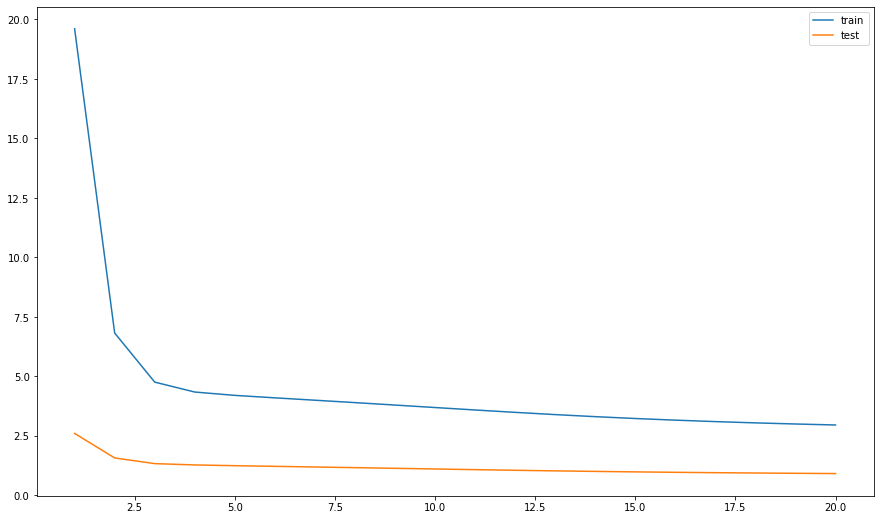

In [11]:
#绘制loss曲线变化图
epoches = np.arange(1, epoch + 1)
train_loss_list = np.array(train_loss_list)
test_loss_list = np.array(test_loss_list)
plt.figure(figsize=(15, 9))
plt.plot(epoches, train_loss_list, label = "train")
plt.plot(epoches, test_loss_list, label = "test")
plt.legend()
plt.plot()

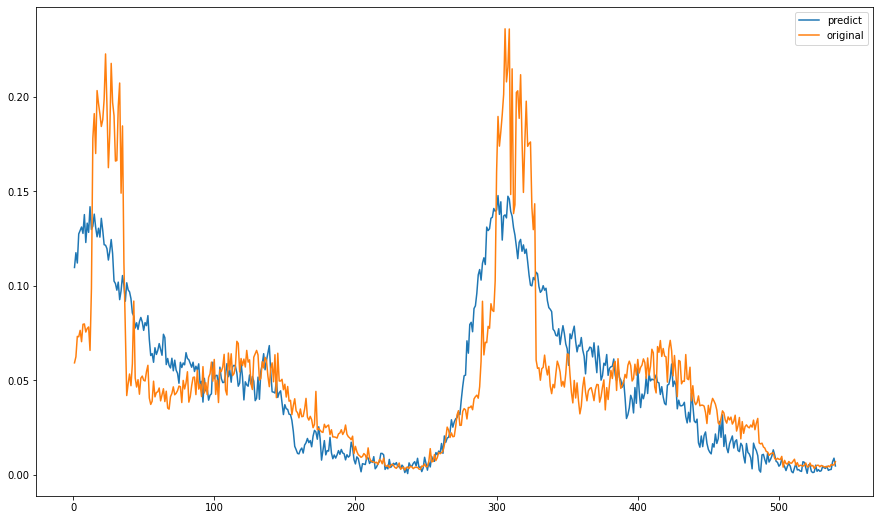

In [13]:
show_preds(15,test_preds,test_label,o_scaler,1,0)